# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os
import sklearn
import itertools
import sklearn
from sklearn import linear_model

In [2]:
# hyperparameters
startyear=1990
coefThreshold  = 0.98

In [3]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


As we can see in the dataframe above, we have several rows (measurements) for the same target. To make the best possible analysis, we would like to use the measurements with most values for each target.

That's why we first count the number of values for each row and then filter the targets for the rows with most values.

In [4]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [5]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [6]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


See which Targets are left in our data frame.

In [9]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [10]:
# create empty dictionary
target_dfs = {}

In [11]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [12]:
# example of Target with more than one Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [13]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [14]:
frames = list(max_dfrows[target] for target in targets)

In [15]:
merged_df = pd.concat(frames, axis=0)

In [16]:
units = list(set(merged_df['Unit']))

We know that most of our Indicators are given in the unit 'percent', but we want to see here what are other units

In [17]:
units.remove('Percent')
units

['Constant USD', 'USD', 'Metric Tons']

Which and how many Indicators are expressed in other units than 'percent'?

In [18]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


### Clean up data frame

To prepare the dataframe for the actual analysis, we remove unused columns and transpose the dataframe, having years of measurements as rows and targets as columns.

In [19]:
# Drop unused columns
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

# transpose
final_t = final_df.T

targets = list(final_t.columns)

Normalize the data set to reduce any covariate shift

In [20]:
def normalize_df(df):
    return (df -df.mean())/df.std()

In [21]:
final_t = normalize_df(final_t)

In [22]:
# shuffle data
final_t_shuffled = sklearn.utils.shuffle(final_t, random_state=200)

### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the (standardized) correlation coefficient is higher than 0.9.

In [23]:
import sklearn

In [24]:
from scipy.stats import pearsonr

def calcCorr(df, target1, target2):
    # list of values
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
                    
    #correlation between two targets
    mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
    t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
    t2_list = list(itertools.compress(t2_list, mask))

                    
    #correlation between two targets
    corrCoef = pearsonr(t1_list, t2_list)[0]
    
    return corrCoef

def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

17.19 6.1
Coefficient 0.5609097275623679
--------------------------


17.19 9.4
Coefficient 0.7056245930988688
--------------------------


17.19 4.2
Coefficient 0.5291994516261366
--------------------------


17.19 9.5
Coefficient 0.5726812942449747
--------------------------


17.19 3.1
Coefficient nan
--------------------------


17.19 7.1
Coefficient -1.0
--------------------------


17.19 3.9
Coefficient nan
--------------------------


17.19 10.c
Coefficient -0.17441410342361807
--------------------------


17.19 17.8
Coefficient 0.5751571077767779
--------------------------


17.19 17.3
Coefficient 0.433233298939833
--------------------------


17.19 12.2
Coefficient 0.8658157338010419
--------------------------


17.19 6.2
Coefficient -0.5687637338785003
--------------------------


17.19 8.1
Coefficient 0.3789990583484148
--------------------------


17.19 14.5
Coefficient nan
--------------------------


17.19 2.1
Coefficient -0.5599098618887113
--------------------------


1

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:2998: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:2999: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(

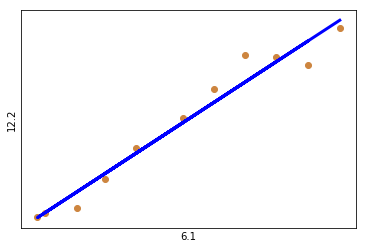

MAE: 0.14114
RMSE: 0.18550
R2: 0.962
6.1 12.2
Coefficient 0.9808911789050258
--------------------------


6.1 6.2
Coefficient -0.9326344800512837
--------------------------


6.1 8.1
Coefficient -0.2255467074419963
--------------------------


6.1 14.5
Coefficient 0.8542351290971306
--------------------------


6.1 2.1
Coefficient -0.916829869620597
--------------------------


6.1 9.2
Coefficient 0.8293404977228922
--------------------------


6.1 17.2
Coefficient 0.9405698445567965
--------------------------


6.1 9.c
Coefficient 0.8758357153946063
--------------------------




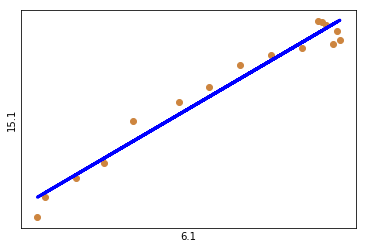

MAE: 0.15932
RMSE: 0.18362
R2: 0.964
6.1 15.1
Coefficient 0.9820845912313038
--------------------------


6.1 3.6
Coefficient -0.3969625235014938
--------------------------


6.1 15.4
Coefficient 0.9786034557886569
--------------------------


6.1 14.4
Coefficient 0.901537266078164
--------------------------


6.1 3.4
Coefficient -0.93050341891725
--------------------------


6.1 8.2
Coefficient -0.009726255398749389
--------------------------


6.1 1.1
Coefficient nan
--------------------------


6.1 7.2
Coefficient 0.5418425807430469
--------------------------


6.1 16.a
Coefficient 0.9724797381388267
--------------------------


6.1 3.3
Coefficient -0.8864832738708248
--------------------------


6.1 16.3
Coefficient -1.0
--------------------------


6.1 15.2
Coefficient -1.0
--------------------------


6.1 6.b
Coefficient nan
--------------------------




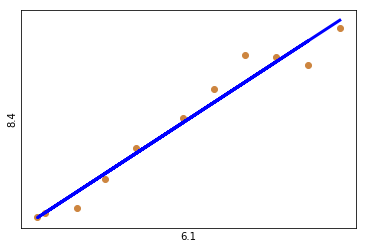

MAE: 0.14114
RMSE: 0.18550
R2: 0.962
6.1 8.4
Coefficient 0.9808911789050258
--------------------------


9.4 4.2
Coefficient 0.9362338335259066
--------------------------




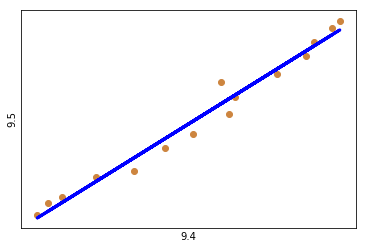

MAE: 0.12508
RMSE: 0.14902
R2: 0.976
9.4 9.5
Coefficient 0.9880321662073264
--------------------------




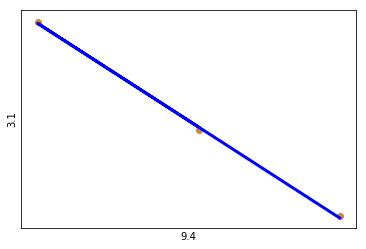

MAE: 0.01943
RMSE: 0.02063
R2: 0.999
9.4 3.1
Coefficient -0.9995856974526323
--------------------------




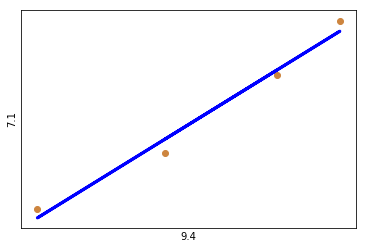

MAE: 0.11397
RMSE: 0.12018
R2: 0.981
9.4 7.1
Coefficient 0.9903241536157872
--------------------------




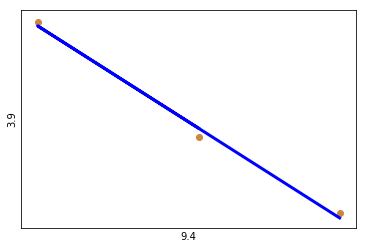

MAE: 0.05835
RMSE: 0.06194
R2: 0.993
9.4 3.9
Coefficient -0.9967275054222731
--------------------------


9.4 10.c
Coefficient -0.9183567152779861
--------------------------


9.4 17.8
Coefficient 0.973740019690207
--------------------------


9.4 17.3
Coefficient 0.9682092579151955
--------------------------




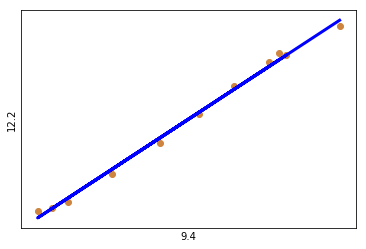

MAE: 0.05920
RMSE: 0.06678
R2: 0.995
9.4 12.2
Coefficient 0.9975440362393049
--------------------------




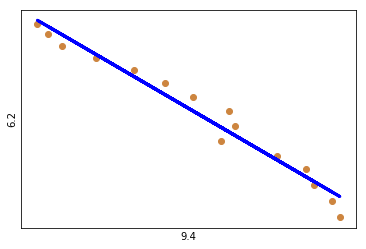

MAE: 0.14416
RMSE: 0.16508
R2: 0.966
9.4 6.2
Coefficient -0.9829123204232983
--------------------------


9.4 8.1
Coefficient -0.12171979800628611
--------------------------


9.4 14.5
Coefficient 0.933499617162947
--------------------------


9.4 2.1
Coefficient -0.9388322179382447
--------------------------


9.4 9.2
Coefficient 0.8961084136207269
--------------------------


9.4 17.2
Coefficient 0.9320243313192957
--------------------------


9.4 9.c
Coefficient 0.872691660669549
--------------------------


9.4 15.1
Coefficient 0.9741002662571399
--------------------------


9.4 3.6
Coefficient -0.47955564455888366
--------------------------




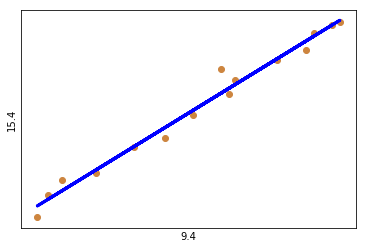

MAE: 0.09210
RMSE: 0.12700
R2: 0.981
9.4 15.4
Coefficient 0.9906385237419474
--------------------------


9.4 14.4
Coefficient 0.8816209955175985
--------------------------




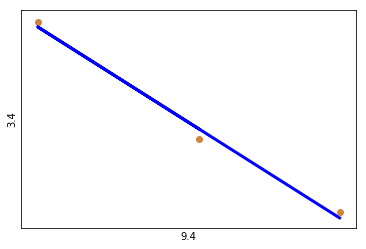

MAE: 0.05820
RMSE: 0.06178
R2: 0.991
9.4 3.4
Coefficient -0.9954556530188572
--------------------------


9.4 8.2
Coefficient 0.07915288157370307
--------------------------


9.4 1.1
Coefficient nan
--------------------------


9.4 7.2
Coefficient 0.5966214528327626
--------------------------




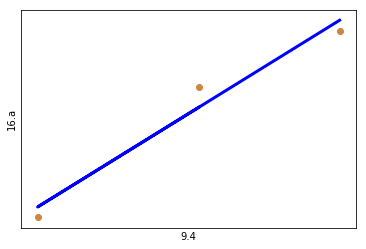

MAE: 0.14975
RMSE: 0.15895
R2: 0.964
9.4 16.a
Coefficient 0.9820698721306446
--------------------------


9.4 3.3
Coefficient -0.9476713756066437
--------------------------


9.4 16.3
Coefficient nan
--------------------------


9.4 15.2
Coefficient 1.0
--------------------------


9.4 6.b
Coefficient nan
--------------------------




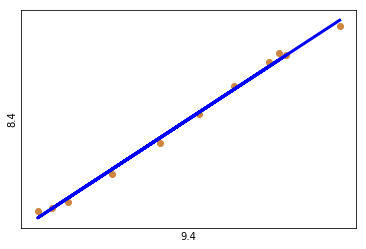

MAE: 0.05920
RMSE: 0.06678
R2: 0.995
9.4 8.4
Coefficient 0.9975440362393049
--------------------------


4.2 9.5
Coefficient 0.9461398641648034
--------------------------


4.2 3.1
Coefficient -1.0
--------------------------


4.2 7.1
Coefficient 0.9554290675576101
--------------------------


4.2 3.9
Coefficient -1.0
--------------------------


4.2 10.c
Coefficient -0.8029527736749904
--------------------------


4.2 17.8
Coefficient 0.9720232868439697
--------------------------


4.2 17.3
Coefficient 0.8479266290589494
--------------------------


4.2 12.2
Coefficient 0.9569108344220997
--------------------------


4.2 6.2
Coefficient -0.9662868232291627
--------------------------


4.2 8.1
Coefficient -0.14714895299480082
--------------------------


4.2 14.5
Coefficient 1.0
--------------------------


4.2 2.1
Coefficient -0.9299704088072611
--------------------------


4.2 9.2
Coefficient 0.774107127894739
--------------------------


4.2 17.2
Coefficient 0.7255815006392615
-----

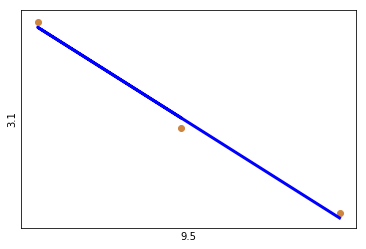

MAE: 0.06438
RMSE: 0.06832
R2: 0.991
9.5 3.1
Coefficient -0.9954454095055351
--------------------------




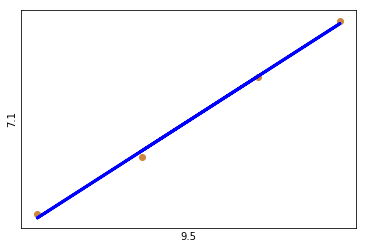

MAE: 0.03643
RMSE: 0.04422
R2: 0.997
9.5 7.1
Coefficient 0.9986956558055883
--------------------------




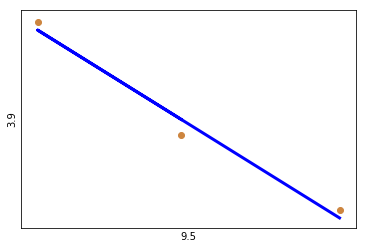

MAE: 0.10620
RMSE: 0.11269
R2: 0.978
9.5 3.9
Coefficient -0.9891246780035441
--------------------------


9.5 10.c
Coefficient -0.8577596534148673
--------------------------




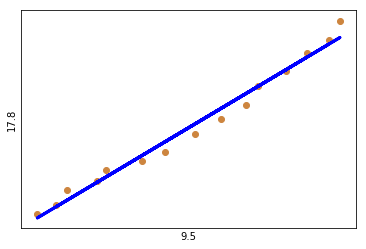

MAE: 0.09971
RMSE: 0.11977
R2: 0.982
9.5 17.8
Coefficient 0.9908548767008797
--------------------------


9.5 17.3
Coefficient 0.9661632648000366
--------------------------


9.5 12.2
Coefficient 0.9750069181566736
--------------------------




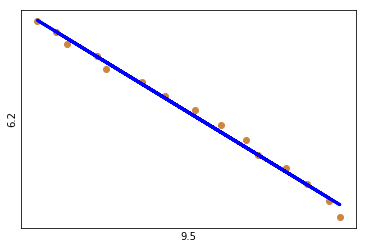

MAE: 0.05726
RMSE: 0.07622
R2: 0.993
9.5 6.2
Coefficient -0.9963819871985091
--------------------------


9.5 8.1
Coefficient -0.2434915498755251
--------------------------


9.5 14.5
Coefficient 0.9553208922586308
--------------------------


9.5 2.1
Coefficient -0.971689172606545
--------------------------


9.5 9.2
Coefficient 0.8385563867270526
--------------------------


9.5 17.2
Coefficient 0.9165487971772471
--------------------------


9.5 9.c
Coefficient 0.8840861128471317
--------------------------


9.5 15.1
Coefficient 0.9582204221191677
--------------------------


9.5 3.6
Coefficient -0.5511647683662297
--------------------------




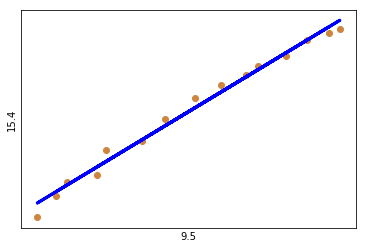

MAE: 0.09233
RMSE: 0.10933
R2: 0.986
9.5 15.4
Coefficient 0.9930704122763044
--------------------------


9.5 14.4
Coefficient 0.8921333805777522
--------------------------




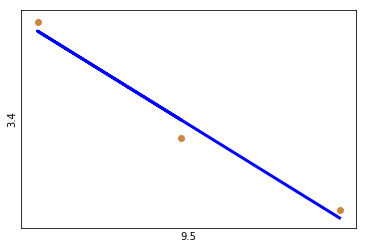

MAE: 0.09865
RMSE: 0.10468
R2: 0.974
9.5 3.4
Coefficient -0.9868965774431583
--------------------------


9.5 8.2
Coefficient -0.060218226147041545
--------------------------


9.5 1.1
Coefficient nan
--------------------------


9.5 7.2
Coefficient 0.6911745283369051
--------------------------


9.5 16.a
Coefficient 0.9673234201397857
--------------------------


9.5 3.3
Coefficient -0.9729430011722686
--------------------------


9.5 16.3
Coefficient nan
--------------------------


9.5 15.2
Coefficient 1.0
--------------------------


9.5 6.b
Coefficient nan
--------------------------


9.5 8.4
Coefficient 0.9750069181566736
--------------------------




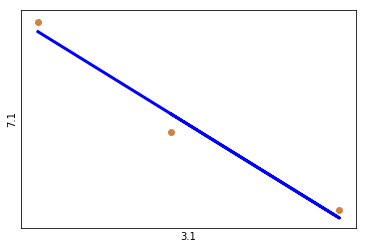

MAE: 0.10050
RMSE: 0.10684
R2: 0.974
3.1 7.1
Coefficient -0.9868621623507102
--------------------------




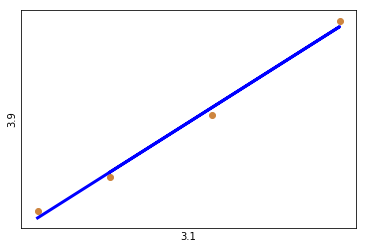

MAE: 0.07108
RMSE: 0.07221
R2: 0.993
3.1 3.9
Coefficient 0.9965178598231698
--------------------------


3.1 10.c
Coefficient nan
--------------------------


3.1 17.8
Coefficient -0.9757430562328929
--------------------------




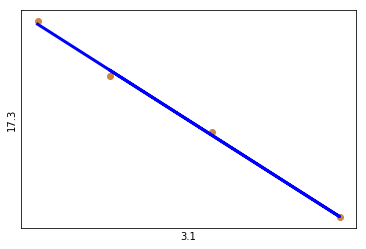

MAE: 0.05631
RMSE: 0.06561
R2: 0.997
3.1 17.3
Coefficient -0.9986345477475925
--------------------------




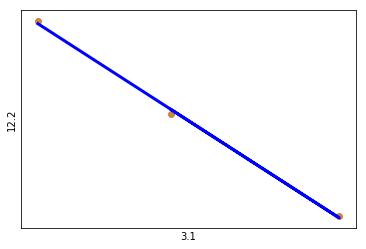

MAE: 0.04010
RMSE: 0.04263
R2: 0.998
3.1 12.2
Coefficient -0.9992291968723098
--------------------------




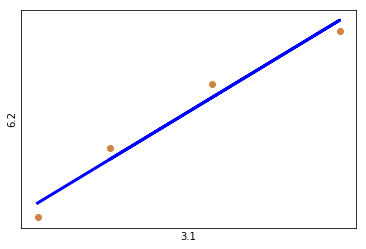

MAE: 0.20653
RMSE: 0.20837
R2: 0.968
3.1 6.2
Coefficient 0.9840478510887246
--------------------------


3.1 8.1
Coefficient 0.7376649432148176
--------------------------


3.1 14.5
Coefficient -0.9418541987327749
--------------------------


3.1 2.1
Coefficient 0.9392123210309292
--------------------------


3.1 9.2
Coefficient -0.9572411715732688
--------------------------


3.1 17.2
Coefficient -0.9435846902744821
--------------------------


3.1 9.c
Coefficient -0.6449665564044781
--------------------------




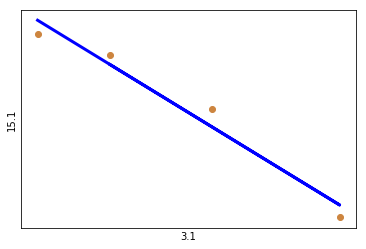

MAE: 0.21230
RMSE: 0.21758
R2: 0.964
3.1 15.1
Coefficient -0.9815967899407817
--------------------------


3.1 3.6
Coefficient -0.06670220163897005
--------------------------




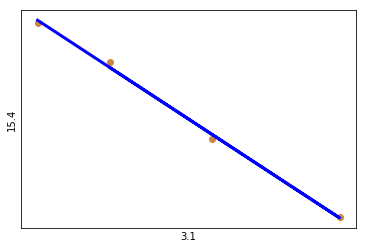

MAE: 0.05407
RMSE: 0.06085
R2: 0.997
3.1 15.4
Coefficient -0.998501004029796
--------------------------


3.1 14.4
Coefficient nan
--------------------------




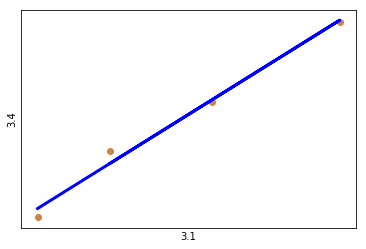

MAE: 0.07225
RMSE: 0.08945
R2: 0.989
3.1 3.4
Coefficient 0.9946518305080976
--------------------------


3.1 8.2
Coefficient 0.21168538570399698
--------------------------


3.1 1.1
Coefficient nan
--------------------------


3.1 7.2
Coefficient -0.024155185900510627
--------------------------


3.1 16.a
Coefficient -0.979745547033195
--------------------------


3.1 3.3
Coefficient 0.9388870775587996
--------------------------


3.1 16.3
Coefficient 1.0
--------------------------


3.1 15.2
Coefficient nan
--------------------------


3.1 6.b
Coefficient nan
--------------------------




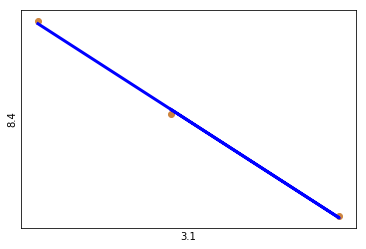

MAE: 0.04010
RMSE: 0.04263
R2: 0.998
3.1 8.4
Coefficient -0.9992291968723098
--------------------------


7.1 3.9
Coefficient -0.9771015844958783
--------------------------


7.1 10.c
Coefficient nan
--------------------------




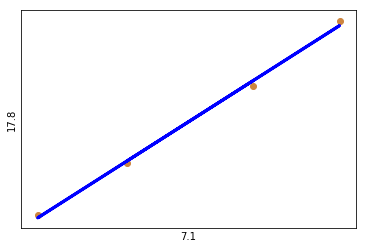

MAE: 0.05303
RMSE: 0.05689
R2: 0.997
7.1 17.8
Coefficient 0.9986264774125925
--------------------------


7.1 17.3
Coefficient 0.975304166291497
--------------------------




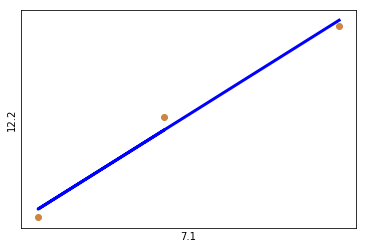

MAE: 0.12505
RMSE: 0.13324
R2: 0.985
7.1 12.2
Coefficient 0.9924438160071323
--------------------------




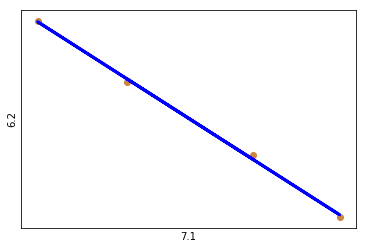

MAE: 0.03497
RMSE: 0.03965
R2: 0.999
7.1 6.2
Coefficient -0.9993367379575052
--------------------------


7.1 8.1
Coefficient -0.7419391190458509
--------------------------


7.1 14.5
Coefficient 0.9729190936907801
--------------------------


7.1 2.1
Coefficient -0.9757500765858448
--------------------------




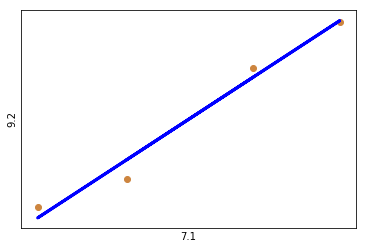

MAE: 0.10563
RMSE: 0.12612
R2: 0.974
7.1 9.2
Coefficient 0.986711676584663
--------------------------


7.1 17.2
Coefficient 0.8435698729483155
--------------------------


7.1 9.c
Coefficient 0.7415007996211567
--------------------------


7.1 15.1
Coefficient 0.9476563027904157
--------------------------


7.1 3.6
Coefficient -0.09537875856974545
--------------------------




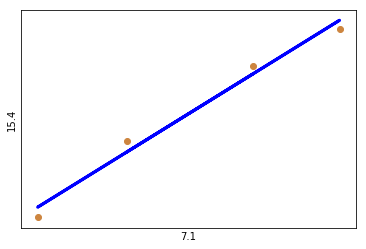

MAE: 0.14335
RMSE: 0.14419
R2: 0.983
7.1 15.4
Coefficient 0.9915017878194363
--------------------------


7.1 14.4
Coefficient nan
--------------------------


7.1 3.4
Coefficient -0.9739256533199434
--------------------------


7.1 8.2
Coefficient -0.20621222540967715
--------------------------


7.1 1.1
Coefficient nan
--------------------------


7.1 7.2
Coefficient 0.7223065227585131
--------------------------


7.1 16.a
Coefficient 0.9482425651756413
--------------------------




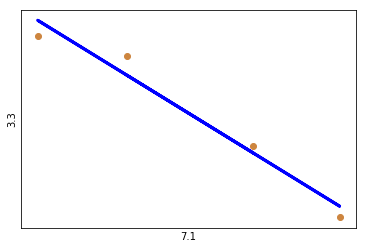

MAE: 0.19301
RMSE: 0.20596
R2: 0.961
7.1 3.3
Coefficient -0.9804717726974136
--------------------------


7.1 16.3
Coefficient nan
--------------------------


7.1 15.2
Coefficient 1.0
--------------------------


7.1 6.b
Coefficient nan
--------------------------




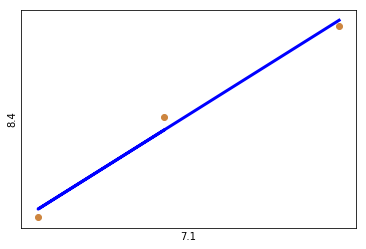

MAE: 0.12505
RMSE: 0.13324
R2: 0.985
7.1 8.4
Coefficient 0.9924438160071323
--------------------------


3.9 10.c
Coefficient nan
--------------------------


3.9 17.8
Coefficient -0.9541030052634786
--------------------------




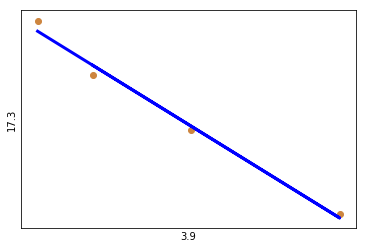

MAE: 0.12401
RMSE: 0.13543
R2: 0.988
3.9 17.3
Coefficient -0.9941695217210466
--------------------------




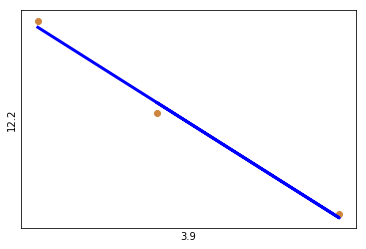

MAE: 0.09279
RMSE: 0.09912
R2: 0.992
3.9 12.2
Coefficient -0.9958256982305764
--------------------------


3.9 6.2
Coefficient 0.9658309013224777
--------------------------


3.9 8.1
Coefficient 0.7089188200331332
--------------------------


3.9 14.5
Coefficient -0.910885573536671
--------------------------


3.9 2.1
Coefficient 0.912151545743789
--------------------------


3.9 9.2
Coefficient -0.9331679707771359
--------------------------


3.9 17.2
Coefficient -0.9632064834811416
--------------------------


3.9 9.c
Coefficient -0.5908227406429751
--------------------------




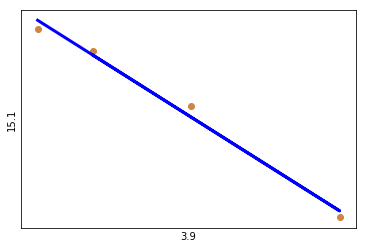

MAE: 0.11809
RMSE: 0.12383
R2: 0.988
3.9 15.1
Coefficient -0.9940766050073868
--------------------------


3.9 3.6
Coefficient -0.1186085802573674
--------------------------




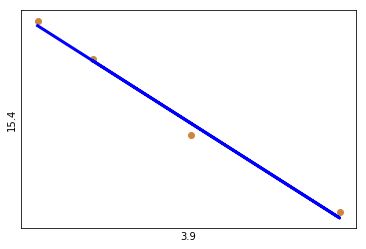

MAE: 0.09072
RMSE: 0.10714
R2: 0.991
3.9 15.4
Coefficient -0.9953449508819756
--------------------------


3.9 14.4
Coefficient nan
--------------------------




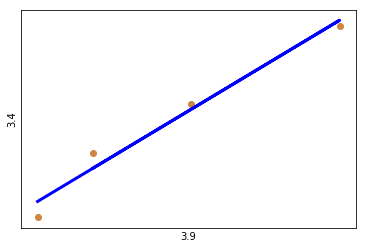

MAE: 0.13050
RMSE: 0.14418
R2: 0.972
3.9 3.4
Coefficient 0.9860435923322884
--------------------------


3.9 8.2
Coefficient 0.15928631084033074
--------------------------


3.9 1.1
Coefficient nan
--------------------------


3.9 7.2
Coefficient 0.02797550464250246
--------------------------




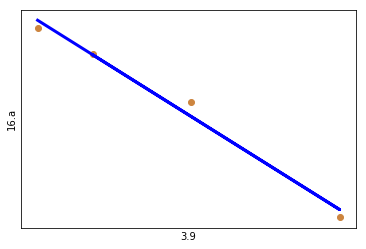

MAE: 0.09334
RMSE: 0.10801
R2: 0.985
3.9 16.a
Coefficient -0.9926490571226106
--------------------------


3.9 3.3
Coefficient 0.9074689604175076
--------------------------


3.9 16.3
Coefficient 1.0
--------------------------


3.9 15.2
Coefficient nan
--------------------------


3.9 6.b
Coefficient nan
--------------------------




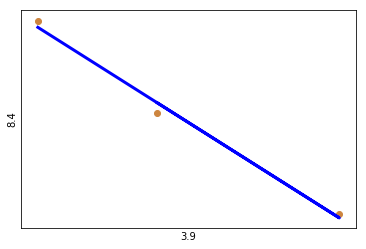

MAE: 0.09279
RMSE: 0.09912
R2: 0.992
3.9 8.4
Coefficient -0.9958256982305764
--------------------------


10.c 17.8
Coefficient -0.9390710019458561
--------------------------


10.c 17.3
Coefficient -0.9721724578938965
--------------------------


10.c 12.2
Coefficient nan
--------------------------


10.c 6.2
Coefficient 0.9336516098377565
--------------------------


10.c 8.1
Coefficient -0.3266480786248126
--------------------------


10.c 14.5
Coefficient nan
--------------------------


10.c 2.1
Coefficient 0.8639940751540554
--------------------------




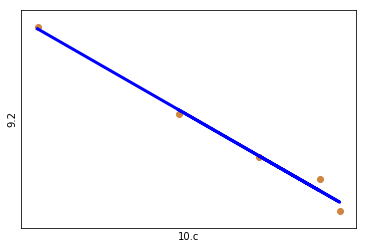

MAE: 0.01080
RMSE: 0.01374
R2: 0.988
10.c 9.2
Coefficient -0.9939776206117683
--------------------------


10.c 17.2
Coefficient -0.9742949912408243
--------------------------


10.c 9.c
Coefficient -0.7584941520036208
--------------------------


10.c 15.1
Coefficient -0.7582037113567897
--------------------------


10.c 3.6
Coefficient nan
--------------------------


10.c 15.4
Coefficient -0.6994903502480878
--------------------------


10.c 14.4
Coefficient 1.0
--------------------------


10.c 3.4
Coefficient nan
--------------------------


10.c 8.2
Coefficient 0.6289238766748966
--------------------------


10.c 1.1
Coefficient nan
--------------------------


10.c 7.2
Coefficient -0.8082515774139288
--------------------------


10.c 16.a
Coefficient nan
--------------------------


10.c 3.3
Coefficient 0.9093464896438372
--------------------------


10.c 16.3
Coefficient nan
--------------------------


10.c 15.2
Coefficient nan
--------------------------


10.c 6.b
Coefficient

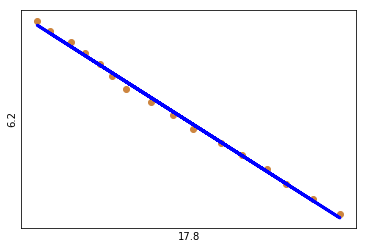

MAE: 0.04886
RMSE: 0.05709
R2: 0.997
17.8 6.2
Coefficient -0.9982604771744986
--------------------------


17.8 8.1
Coefficient -0.1852807378124997
--------------------------




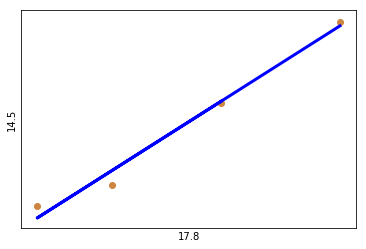

MAE: 0.08733
RMSE: 0.10556
R2: 0.983
17.8 14.5
Coefficient 0.9912735616996395
--------------------------


17.8 2.1
Coefficient -0.9782537852162339
--------------------------


17.8 9.2
Coefficient 0.849513110153676
--------------------------


17.8 17.2
Coefficient 0.8946399657469059
--------------------------


17.8 9.c
Coefficient 0.8676031455852277
--------------------------


17.8 15.1
Coefficient 0.9129212785691038
--------------------------


17.8 3.6
Coefficient -0.6010854221067646
--------------------------


17.8 15.4
Coefficient 0.9690258251555197
--------------------------


17.8 14.4
Coefficient 0.901827190885061
--------------------------




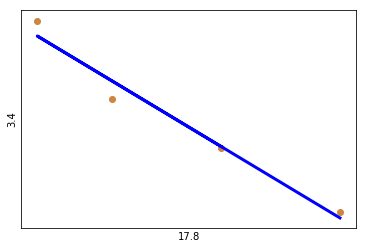

MAE: 0.12637
RMSE: 0.15114
R2: 0.970
17.8 3.4
Coefficient -0.9846534543103882
--------------------------


17.8 8.2
Coefficient -0.11619543544121269
--------------------------


17.8 1.1
Coefficient nan
--------------------------


17.8 7.2
Coefficient 0.7525436246247122
--------------------------


17.8 16.a
Coefficient 0.913492445662747
--------------------------




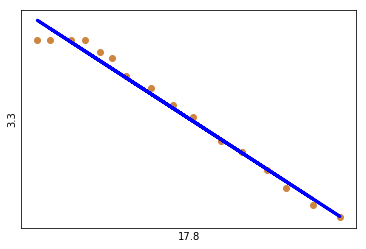

MAE: 0.09281
RMSE: 0.12488
R2: 0.983
17.8 3.3
Coefficient -0.9916476196763732
--------------------------


17.8 16.3
Coefficient -1.0
--------------------------


17.8 15.2
Coefficient 1.0
--------------------------


17.8 6.b
Coefficient nan
--------------------------


17.8 8.4
Coefficient 0.9574922058297233
--------------------------


17.3 12.2
Coefficient 0.9717775401027658
--------------------------


17.3 6.2
Coefficient -0.9590986826614145
--------------------------


17.3 8.1
Coefficient -0.2514423655799653
--------------------------


17.3 14.5
Coefficient 0.9418917076051909
--------------------------


17.3 2.1
Coefficient -0.9101537706469875
--------------------------


17.3 9.2
Coefficient 0.8280793624592161
--------------------------


17.3 17.2
Coefficient 0.9466013661683573
--------------------------


17.3 9.c
Coefficient 0.8387884290002132
--------------------------




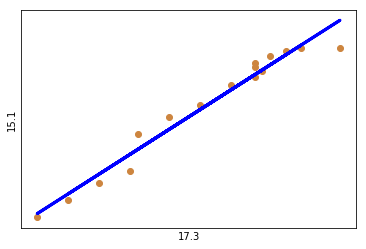

MAE: 0.14956
RMSE: 0.18861
R2: 0.963
17.3 15.1
Coefficient 0.981087411101381
--------------------------


17.3 3.6
Coefficient -0.3830583578221878
--------------------------




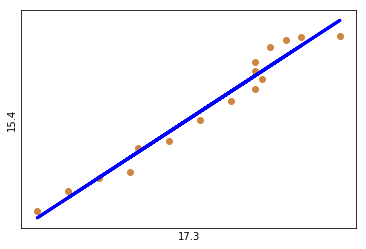

MAE: 0.16512
RMSE: 0.18415
R2: 0.963
17.3 15.4
Coefficient 0.9810799411784374
--------------------------


17.3 14.4
Coefficient 0.8176452048262536
--------------------------




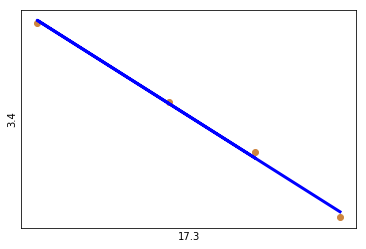

MAE: 0.04627
RMSE: 0.05138
R2: 0.996
17.3 3.4
Coefficient -0.9982388300390304
--------------------------


17.3 8.2
Coefficient -0.07624348873526794
--------------------------


17.3 1.1
Coefficient nan
--------------------------


17.3 7.2
Coefficient 0.5221653930567981
--------------------------


17.3 16.a
Coefficient 0.978255086728194
--------------------------


17.3 3.3
Coefficient -0.9071673688690943
--------------------------


17.3 16.3
Coefficient -1.0
--------------------------


17.3 15.2
Coefficient 1.0
--------------------------


17.3 6.b
Coefficient nan
--------------------------


17.3 8.4
Coefficient 0.9717775401027658
--------------------------


12.2 6.2
Coefficient -0.9717460346809231
--------------------------


12.2 8.1
Coefficient -0.11786120286058854
--------------------------


12.2 14.5
Coefficient 0.9372059503018323
--------------------------


12.2 2.1
Coefficient -0.8650963199873207
--------------------------


12.2 9.2
Coefficient 0.800578117167294
------

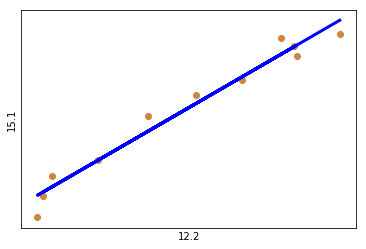

MAE: 0.13619
RMSE: 0.16587
R2: 0.967
12.2 15.1
Coefficient 0.9831864765083226
--------------------------


12.2 3.6
Coefficient 0.027482485496465488
--------------------------


12.2 15.4
Coefficient 0.979420389142252
--------------------------


12.2 14.4
Coefficient 0.788895368938072
--------------------------




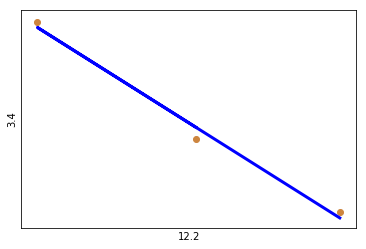

MAE: 0.06460
RMSE: 0.06854
R2: 0.989
12.2 3.4
Coefficient -0.9944031065414566
--------------------------


12.2 8.2
Coefficient 0.2472511486507629
--------------------------


12.2 1.1
Coefficient nan
--------------------------


12.2 7.2
Coefficient -0.011608155542496083
--------------------------




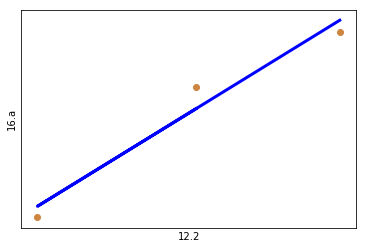

MAE: 0.15797
RMSE: 0.16762
R2: 0.960
12.2 16.a
Coefficient 0.9800404520623481
--------------------------


12.2 3.3
Coefficient -0.9185172896104286
--------------------------


12.2 16.3
Coefficient nan
--------------------------


12.2 15.2
Coefficient nan
--------------------------


12.2 6.b
Coefficient nan
--------------------------


12.2 8.4
Coefficient 1.0
--------------------------


6.2 8.1
Coefficient 0.1924176719042905
--------------------------




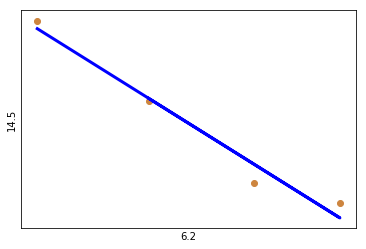

MAE: 0.12017
RMSE: 0.13800
R2: 0.970
6.2 14.5
Coefficient -0.9850404439878131
--------------------------


6.2 2.1
Coefficient 0.9759405924633685
--------------------------


6.2 9.2
Coefficient -0.8563738992028102
--------------------------


6.2 17.2
Coefficient -0.9138419902281629
--------------------------


6.2 9.c
Coefficient -0.876218102047902
--------------------------


6.2 15.1
Coefficient -0.933055855416781
--------------------------


6.2 3.6
Coefficient 0.5708106930690756
--------------------------


6.2 15.4
Coefficient -0.9798366785724999
--------------------------


6.2 14.4
Coefficient -0.8947879013966934
--------------------------




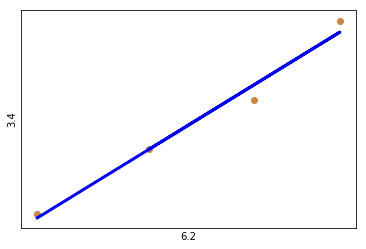

MAE: 0.09294
RMSE: 0.11686
R2: 0.982
6.2 3.4
Coefficient 0.9908539501288818
--------------------------


6.2 8.2
Coefficient 0.10405267630469782
--------------------------


6.2 1.1
Coefficient nan
--------------------------


6.2 7.2
Coefficient -0.7235387926190321
--------------------------


6.2 16.a
Coefficient -0.9299842745066966
--------------------------




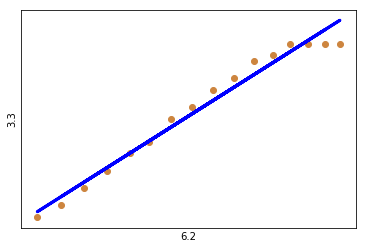

MAE: 0.12987
RMSE: 0.15717
R2: 0.974
6.2 3.3
Coefficient 0.9867377868030519
--------------------------


6.2 16.3
Coefficient 1.0
--------------------------


6.2 15.2
Coefficient -1.0
--------------------------


6.2 6.b
Coefficient nan
--------------------------


6.2 8.4
Coefficient -0.9717460346809231
--------------------------


8.1 14.5
Coefficient -0.7683700115676466
--------------------------


8.1 2.1
Coefficient 0.2593066449395189
--------------------------


8.1 9.2
Coefficient 0.24199781938712522
--------------------------


8.1 17.2
Coefficient -0.15128515097781184
--------------------------


8.1 9.c
Coefficient -0.1425064270276867
--------------------------


8.1 15.1
Coefficient -0.20173021332326485
--------------------------


8.1 3.6
Coefficient 0.5135971202783383
--------------------------


8.1 15.4
Coefficient -0.2256516518781908
--------------------------


8.1 14.4
Coefficient -0.4742658035338765
--------------------------


8.1 3.4
Coefficient 0.8026007171525709

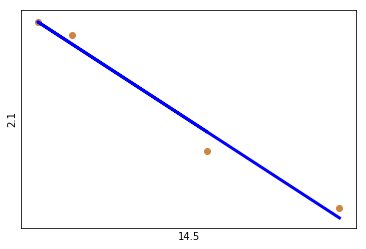

MAE: 0.08741
RMSE: 0.10690
R2: 0.978
14.5 2.1
Coefficient -0.9891491091524577
--------------------------




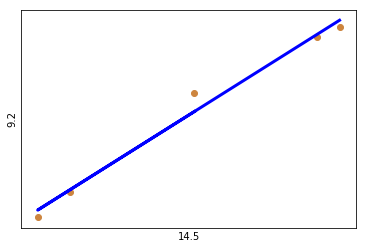

MAE: 0.08447
RMSE: 0.10804
R2: 0.985
14.5 9.2
Coefficient 0.9926074627174569
--------------------------


14.5 17.2
Coefficient 0.8558064790253034
--------------------------


14.5 9.c
Coefficient 0.8369080347403536
--------------------------


14.5 15.1
Coefficient 0.8721150839007734
--------------------------


14.5 3.6
Coefficient -0.322887955348015
--------------------------


14.5 15.4
Coefficient 0.9464891754374256
--------------------------


14.5 14.4
Coefficient nan
--------------------------


14.5 3.4
Coefficient -0.9530584416826032
--------------------------


14.5 8.2
Coefficient -0.5453439372401109
--------------------------


14.5 1.1
Coefficient nan
--------------------------


14.5 7.2
Coefficient 0.40747609762927023
--------------------------


14.5 16.a
Coefficient 0.88171791912115
--------------------------




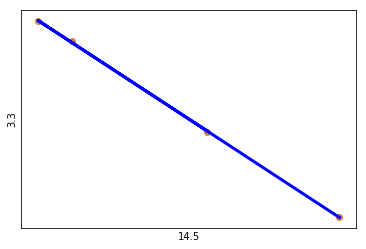

MAE: 0.01766
RMSE: 0.01907
R2: 1.000
14.5 3.3
Coefficient -0.9998536145793242
--------------------------


14.5 16.3
Coefficient -1.0
--------------------------


14.5 15.2
Coefficient nan
--------------------------


14.5 6.b
Coefficient nan
--------------------------


14.5 8.4
Coefficient 0.9372059503018323
--------------------------


2.1 9.2
Coefficient -0.8210704971629079
--------------------------


2.1 17.2
Coefficient -0.8560703416313485
--------------------------


2.1 9.c
Coefficient -0.9126994567627709
--------------------------


2.1 15.1
Coefficient -0.8840293608975545
--------------------------


2.1 3.6
Coefficient 0.7346685538287621
--------------------------


2.1 15.4
Coefficient -0.9537622942289661
--------------------------


2.1 14.4
Coefficient -0.9034555513474544
--------------------------


2.1 3.4
Coefficient 0.9359767379021524
--------------------------


2.1 8.2
Coefficient 0.17797339220611597
--------------------------


2.1 1.1
Coefficient 1.0
------------

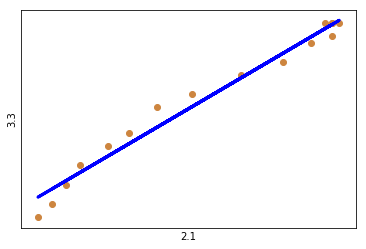

MAE: 0.12511
RMSE: 0.15109
R2: 0.976
2.1 3.3
Coefficient 0.9877502596564229
--------------------------




/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3013: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))


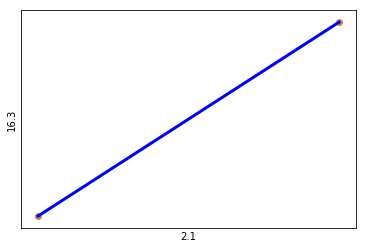

MAE: 0.00000
RMSE: 0.00000
R2: nan
2.1 16.3
Coefficient 0.9999999999999998
--------------------------


2.1 15.2
Coefficient -1.0
--------------------------


2.1 6.b
Coefficient nan
--------------------------


2.1 8.4
Coefficient -0.8650963199873207
--------------------------


9.2 17.2
Coefficient 0.8248385612296656
--------------------------


9.2 9.c
Coefficient 0.8455682975486154
--------------------------


9.2 15.1
Coefficient 0.8471533177587136
--------------------------


9.2 3.6
Coefficient -0.6886050015856264
--------------------------


9.2 15.4
Coefficient 0.8693173253981427
--------------------------


9.2 14.4
Coefficient 0.49846131696173557
--------------------------


9.2 3.4
Coefficient -0.9552353685524276
--------------------------


9.2 8.2
Coefficient 0.2910196727810952
--------------------------


9.2 1.1
Coefficient nan
--------------------------


9.2 7.2
Coefficient 0.4342101804872266
--------------------------


9.2 16.a
Coefficient 0.9062914142845478
-------

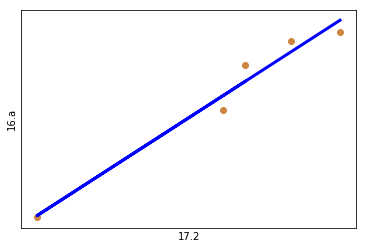

MAE: 0.14593
RMSE: 0.16158
R2: 0.967
17.2 16.a
Coefficient 0.9835475615858102
--------------------------


17.2 3.3
Coefficient -0.8583533542390035
--------------------------


17.2 16.3
Coefficient -1.0
--------------------------


17.2 15.2
Coefficient 1.0
--------------------------


17.2 6.b
Coefficient nan
--------------------------


17.2 8.4
Coefficient 0.9219675108953511
--------------------------


9.c 15.1
Coefficient 0.8334433918500376
--------------------------


9.c 3.6
Coefficient -0.9597680047136002
--------------------------


9.c 15.4
Coefficient 0.8758055130846056
--------------------------


9.c 14.4
Coefficient 0.6169527000098497
--------------------------


9.c 3.4
Coefficient -0.643196885749551
--------------------------


9.c 8.2
Coefficient -0.004727375551902716
--------------------------


9.c 1.1
Coefficient nan
--------------------------


9.c 7.2
Coefficient 0.6774739156977707
--------------------------


9.c 16.a
Coefficient 0.4912424766926737
-------------

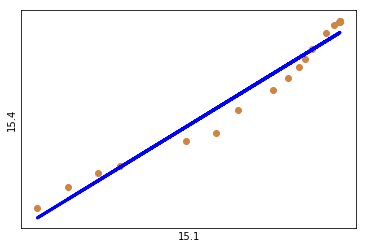

MAE: 0.16922
RMSE: 0.18739
R2: 0.963
15.1 15.4
Coefficient 0.9812335543842363
--------------------------


15.1 14.4
Coefficient 0.8512264995990855
--------------------------


15.1 3.4
Coefficient -0.9654636181776785
--------------------------


15.1 8.2
Coefficient -0.012396964547791217
--------------------------


15.1 1.1
Coefficient nan
--------------------------


15.1 7.2
Coefficient 0.47320426250229064
--------------------------




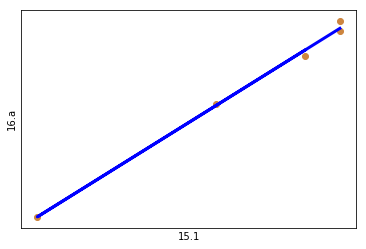

MAE: 0.04321
RMSE: 0.05447
R2: 0.996
15.1 16.a
Coefficient 0.9981438473801353
--------------------------


15.1 3.3
Coefficient -0.8725053823522408
--------------------------




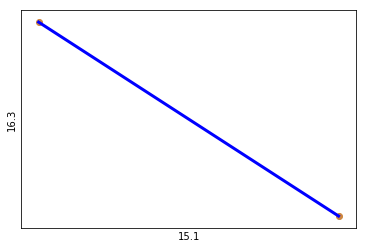

MAE: 0.00000
RMSE: 0.00000
R2: nan
15.1 16.3
Coefficient -0.9999999999999999
--------------------------


15.1 15.2
Coefficient 1.0
--------------------------


15.1 6.b
Coefficient -1.0
--------------------------




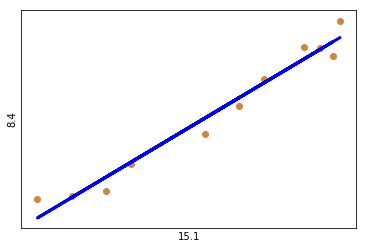

MAE: 0.14510
RMSE: 0.17411
R2: 0.967
15.1 8.4
Coefficient 0.9831864765083226
--------------------------


3.6 15.4
Coefficient -0.49759375015253154
--------------------------




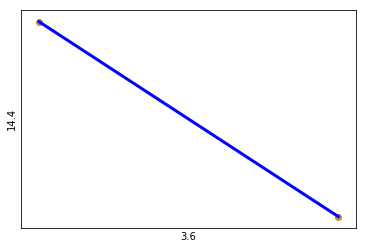

MAE: 0.00000
RMSE: 0.00000
R2: nan
3.6 14.4
Coefficient -0.9999999999999998
--------------------------


3.6 3.4
Coefficient -0.1329413142111511
--------------------------


3.6 8.2
Coefficient 0.3138678439264044
--------------------------


3.6 1.1
Coefficient nan
--------------------------




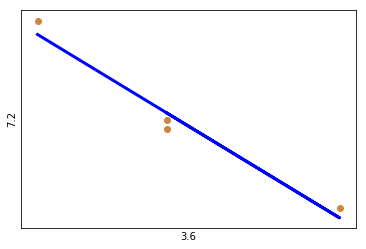

MAE: 0.17394
RMSE: 0.18083
R2: 0.967
3.6 7.2
Coefficient -0.9831514648137984
--------------------------


3.6 16.a
Coefficient 0.22565702830517362
--------------------------


3.6 3.3
Coefficient 0.7310903510372195
--------------------------


3.6 16.3
Coefficient nan
--------------------------


3.6 15.2
Coefficient nan
--------------------------


3.6 6.b
Coefficient nan
--------------------------


3.6 8.4
Coefficient 0.027482485496465488
--------------------------


15.4 14.4
Coefficient 0.8860862068939691
--------------------------




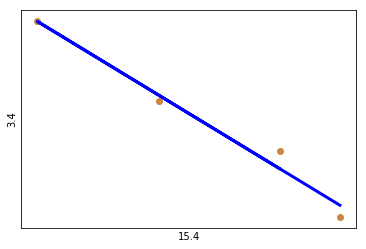

MAE: 0.10558
RMSE: 0.13152
R2: 0.977
15.4 3.4
Coefficient -0.9884011415401027
--------------------------


15.4 8.2
Coefficient -0.08929823205504434
--------------------------


15.4 1.1
Coefficient nan
--------------------------


15.4 7.2
Coefficient 0.62204455247759
--------------------------




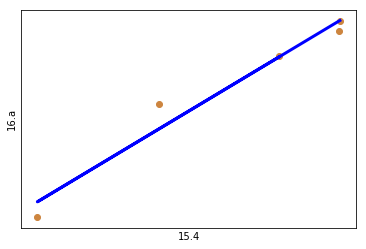

MAE: 0.12906
RMSE: 0.17138
R2: 0.963
15.4 16.a
Coefficient 0.9814714216876664
--------------------------


15.4 3.3
Coefficient -0.9456141392037747
--------------------------


15.4 16.3
Coefficient -1.0
--------------------------


15.4 15.2
Coefficient 1.0
--------------------------




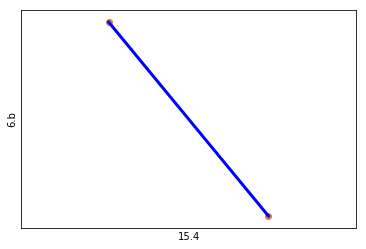

MAE: 0.00000
RMSE: 0.00000
R2: nan
15.4 6.b
Coefficient -0.9999999999999999
--------------------------


15.4 8.4
Coefficient 0.979420389142252
--------------------------


14.4 3.4
Coefficient nan
--------------------------


14.4 8.2
Coefficient -0.41480924936264646
--------------------------


14.4 1.1
Coefficient nan
--------------------------


14.4 7.2
Coefficient 0.5346757954338553
--------------------------


14.4 16.a
Coefficient nan
--------------------------


14.4 3.3
Coefficient -0.8591317262549709
--------------------------


14.4 16.3
Coefficient nan
--------------------------


14.4 15.2
Coefficient nan
--------------------------


14.4 6.b
Coefficient nan
--------------------------


14.4 8.4
Coefficient 0.788895368938072
--------------------------


3.4 8.2
Coefficient 0.3113886204408732
--------------------------


3.4 1.1
Coefficient nan
--------------------------


3.4 7.2
Coefficient 0.042414023783910945
--------------------------


3.4 16.a
Coefficient -0.9659568

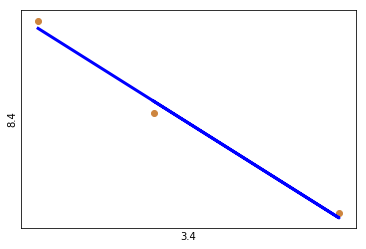

MAE: 0.10721
RMSE: 0.11473
R2: 0.989
3.4 8.4
Coefficient -0.9944031065414566
--------------------------


8.2 1.1
Coefficient nan
--------------------------


8.2 7.2
Coefficient -0.41318134530556966
--------------------------


8.2 16.a
Coefficient -0.30966290921820144
--------------------------


8.2 3.3
Coefficient 0.13109832230550011
--------------------------


8.2 16.3
Coefficient 1.0
--------------------------


8.2 15.2
Coefficient -1.0
--------------------------


8.2 6.b
Coefficient nan
--------------------------


8.2 8.4
Coefficient 0.2472511486507629
--------------------------


1.1 7.2
Coefficient nan
--------------------------


1.1 16.a
Coefficient nan
--------------------------


1.1 3.3
Coefficient nan
--------------------------


1.1 16.3
Coefficient nan
--------------------------


1.1 15.2
Coefficient nan
--------------------------


1.1 6.b
Coefficient nan
--------------------------


1.1 8.4
Coefficient nan
--------------------------


7.2 16.a
Coefficient -0.136

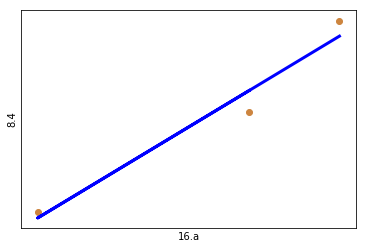

MAE: 0.19829
RMSE: 0.21588
R2: 0.960
16.a 8.4
Coefficient 0.9800404520623481
--------------------------


3.3 16.3
Coefficient 1.0
--------------------------


3.3 15.2
Coefficient -1.0
--------------------------


3.3 6.b
Coefficient nan
--------------------------


3.3 8.4
Coefficient -0.9185172896104286
--------------------------


16.3 15.2
Coefficient nan
--------------------------


16.3 6.b
Coefficient nan
--------------------------


16.3 8.4
Coefficient nan
--------------------------


15.2 6.b
Coefficient nan
--------------------------


15.2 8.4
Coefficient nan
--------------------------


6.b 8.4
Coefficient nan
--------------------------




In [25]:
keptPairs = list()
processedPairs = list()
discardedPairs = list()
edgecolor = list()
pairsAndRel = {}


for targetx in targets:     #loop over all targets
        
        for targety in targets:
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    coef = calcCorr(final_t_shuffled, targetx, targety)
                    
                    # filter out independant variables (coefficient close to 0, coefficient > 100)
                    if (coefThreshold < np.abs(coef) < 1):
                            
                        keptPairs.extend([tuple((targetx, targety))])

                        if coef > 0: edge_color = 'g'#edgecolor.append('g')
                        else: edge_color = 'r'
                                    
                        edgecolor.append(edge_color)
                        pairsAndRel[targetx, targety] = edge_color
                        
                        
                        X = final_t_shuffled[targetx].reshape(-1,1)
                        Y = final_t_shuffled[targety].reshape(-1,1)
                        
                        # apply mask to lists to filter out pairs containing any NaNs
                        mask = ~pd.isnull(X) & ~pd.isnull(Y)

                        X = X[mask].reshape(-1, 1)
                        Y = Y[mask].reshape(-1, 1)
                        
                        linreg = linear_model.LinearRegression()
                        linreg.fit(X, Y)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X)
                        
                        
                        mae, rae, rmse, r2 = compute_error(Y, y_pred)
                        
                        plt.scatter(X, Y, color='peru')
                        plt.plot(X, y_pred, color='blue', linewidth=3)

                        plt.xticks(())
                        plt.yticks(())
                        plt.xlabel(targetx)
                        plt.ylabel(targety)
                        plt.show()
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))

                    else: discardedPairs.extend([[targetx, targety]])

                    print(targetx, targety)
                    print('Coefficient', coef)
                    print('--------------------------')
                    print('\n')

#print(keptPairs)

In [ ]:
print("Total number of connections found: ", len(keptPairs))
print("The following target pairs have a linear correlation:", keptPairs)

### Graphical Models

In [28]:
import networkx as nx

In [29]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

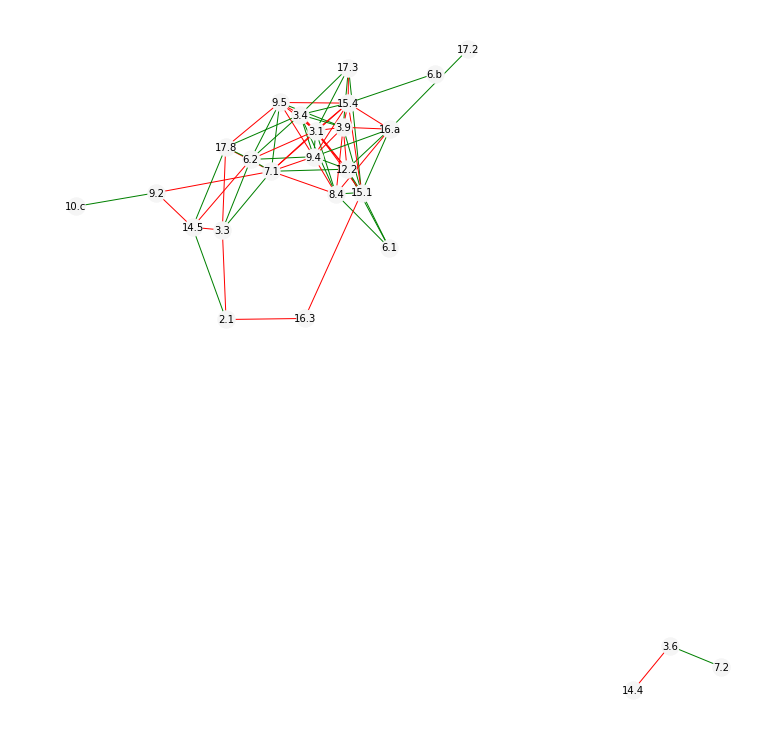

In [30]:
pos2 = nx.spring_layout(G1) # choose layout

plt.figure(1,figsize=(10,10)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.savefig("structure.png")
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph and are plotted closer together. There are also some targets that are only connected to one other target.

Positive interconnections are indicated by a green, negative by a red edge.

In [31]:
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

size = 1024,1024
circles = Image.open("Circle-Designs-01.png")
circles = circles.resize(size, Image.ANTIALIAS)
plot = Image.open("structure.png")
plot = plot.resize(size, Image.ANTIALIAS)
overlay = Image.blend(circles, plot,alpha=0.7)
#overlay.show()
#overlay.save("final.png")

To extract the cliques (complete subgraphs of the graph) that already are visible in the graph above, we use networkx' inbuilt function find_cliques(G).

We would like to make our imputations first on one of these cliques, actually on one that has the most members.


In [32]:
clique_list = list(nx.find_cliques(G1))
clique_list

[['7.2', '3.6'],
 ['6.1', '15.1', '12.2'],
 ['6.1', '15.1', '8.4'],
 ['16.a', '17.2'],
 ['16.a', '3.9', '9.4', '8.4'],
 ['16.a', '3.9', '9.4', '15.4'],
 ['16.a', '3.9', '9.4', '12.2'],
 ['16.a', '3.9', '15.1', '8.4'],
 ['16.a', '3.9', '15.1', '15.4'],
 ['16.a', '3.9', '15.1', '12.2'],
 ['3.3', '6.2', '17.8', '14.5'],
 ['3.3', '6.2', '17.8', '7.1'],
 ['3.3', '2.1', '14.5'],
 ['16.3', '2.1'],
 ['16.3', '15.1'],
 ['3.6', '14.4'],
 ['3.1', '9.4', '3.4', '6.2', '9.5'],
 ['3.1', '9.4', '3.4', '3.9', '9.5', '15.4'],
 ['3.1', '9.4', '3.4', '3.9', '8.4'],
 ['3.1', '9.4', '3.4', '3.9', '12.2'],
 ['3.1', '9.4', '7.1', '9.5', '6.2'],
 ['3.1', '9.4', '7.1', '9.5', '15.4'],
 ['3.1', '9.4', '7.1', '8.4'],
 ['3.1', '9.4', '7.1', '12.2'],
 ['3.1', '15.1', '3.9', '17.3', '15.4'],
 ['3.1', '15.1', '3.9', '12.2'],
 ['3.1', '15.1', '3.9', '8.4'],
 ['3.1', '17.3', '3.4', '15.4', '3.9'],
 ['14.5', '9.2'],
 ['9.2', '7.1'],
 ['9.2', '10.c'],
 ['6.b', '15.4'],
 ['17.8', '6.2', '9.5', '3.4'],
 ['17.8', '6.2', '9

In [33]:
# finding clique containing most nodes
length = 0
for c in clique_list:
    if len(c) > length:
        length = len(c)
        max_clique = c

In [34]:
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph()
    if len(L)>1:
        if G.is_directed():
            edges = itertools.permutations(L,2)
        else:
            edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G


In [35]:
cliqueGraph = complete_graph_from_list(max_clique)

In [36]:
cliqueGraph_edges = list(cliqueGraph.edges)
pairsDictListKeys = list(pairsAndRel.keys())

In [37]:
clique_e_color = []
for edge in cliqueGraph_edges:
    if edge in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge])
    elif edge[::-1] in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge[::-1]])

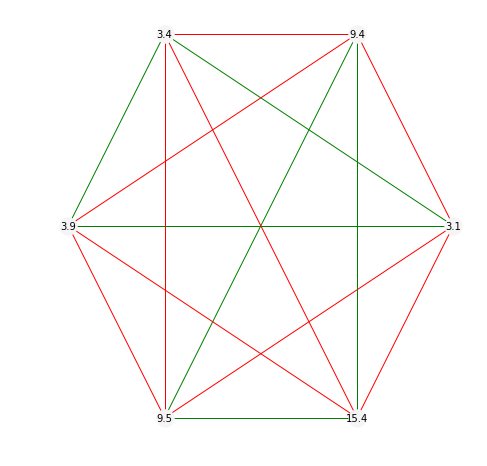

In [38]:
#cliqueGraph.add_nodes_from(max_clique)
pos9 = nx.shell_layout(cliqueGraph)
plt.figure(1,figsize=(6,6)) 
nx.draw(cliqueGraph,pos9, with_labels=True, font_size=10, edge_color=clique_e_color, node_color='whitesmoke')
plt.show()

In [39]:
print('Our max clique consists of the following targets: ', cliqueGraph.nodes)

Our max clique consists of the following targets:  ['3.1', '9.4', '3.4', '3.9', '9.5', '15.4']


# 2. Build temporal model to infer missing observations

We have a temporal model with missing observations as NaNs, and want to infer them according to their correlated targets and their own time series development. Therefore, we design a linear dynamical system with inputs, including an autoregressive model of order 2.

## Define STAN model

From now on, we can actually forget all information we've gotten so far. With the implementation in STAN, we will gain insights for the following two questions in one single model (wow - so amazing :-) ):

**1. How are Targets correlated?**

**2. What are expectable values for missing observations (imputing)?**

Note that we observe two time-series simultaneously. We will model the correlations between the two time-series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or (equivalent):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the model described above is the **covariance matrix $\boldsymbol\Sigma$** which embodies the object that will allow us to capture the correlations between the two time-series.

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a *scale* and a *matrix*, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

Similar to any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but something weakly informative like a half-Cauchy distribution with a small scale is recommended, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior like:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

    multi_normal(mu, quad_form_diag(Omega, tau))


To impute missing observations, we do

\begin{align}
y_{t} &\sim \mathcal{N} \Big(\beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{T} y_{t-T} \Big)
\end{align}


**Note** that we want to make the missing observation dependent on two previous observations. This is equivalent to define an autoregressive model of order 2.

<img src="pgm.png">

In [40]:
SDG_STAN="""
data {
    int<lower = 0> N_obs1;
    int<lower = 0> N_mis1;    // how many do we want to infer
    int<lower = 0> N_obs2;  
    int<lower = 0> N_mis2;
    int<lower = 1, upper = N_obs1 + N_mis1> ix_obs1[N_obs1];    // index for observed time steps of target 1
    int<lower = 1, upper = N_obs1 + N_mis1> ix_mis1[N_mis1];
    int<lower = 1, upper = N_obs2 + N_mis2> ix_obs2[N_obs2];    // index for observed time steps of target 2
    int<lower = 1, upper = N_obs2 + N_mis2> ix_mis2[N_mis2];
    real y_obs1[N_obs1];         // observed time-series data for target 1
    real y_obs2[N_obs2];         // observed time-series data for target 2
}

transformed data {
    int<lower = 0> T = N_obs1 + N_mis1;  // length of the time-series
}

parameters {
    vector[2] beta[2];            // state transition coefficients 
    corr_matrix[2] Omega;       // gives us the correlation with **Omega[1,2]=Omega[2,1]=Cov(1,2)**; Omega[1,1]=Var(1);Omega[2,2]=Var(2)    1 is target 1, 2 is target 2
    vector<lower=0>[2] tau;     // uncertainty in the latent space
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis1];        // missing time-series data to infer for target 1
    real y_mis2[N_mis2];        // missing time-series data to infer for target 2
}

transformed parameters {
    real y1[T];
    real y2[T];
    matrix[2,2] L_sigma;
    y1[ix_obs1] = y_obs1;
    y1[ix_mis1] = y_mis1;
    y2[ix_obs2] = y_obs2;
    y2[ix_mis2] = y_mis2;
}

model {
    for(i in 1:2)                   
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(1);         // STAN manual Section 63.1 (recommendation is lkj_corr)
    sigma ~ cauchy(0,5);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first latent state
    z[2,:] ~ normal(0,1);           // prior on second latent state
    
    for(t in 3:T) {
        vector[2] mu;                          // mu is a vector of the means of our multivariate normal 
        mu[1] = beta[1]' * z[(t-2):(t-1),1];   // mu[1] is the mean of target 1 
        mu[2] = beta[2]' * z[(t-2):(t-1),2];   // mu[2] is the mean of target 2
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood for target 1
    y2 ~ normal(z[:,2], sigma);    // likelihood for target 2
}
"""

### What targets are in our clique?

We will work for the rest of the notebook with this single clique.

In [41]:
clique_nodes = list(cliqueGraph.nodes)
clique_nodes

['3.1', '9.4', '3.4', '3.9', '9.5', '15.4']

In [42]:
clique_df_t = final_t[clique_nodes]

In [43]:
clique_df_t = clique_df_t[clique_df_t.index > str(startyear)]

In [44]:
g1_nodes = list(G1.nodes)
g1_df_t = final_t[g1_nodes]
g1_df_t = g1_df_t[g1_df_t.index > str(startyear)]

## What is observed, what is missing?

- N_obs: Number of observed values (length of loc array)
- N_mis: Number of missing values (length of loc array)
- ix_obs: indices of observed values
- ix_mis: indices of missing values
- y_obs: observed values

In [45]:
# prepare data for STAN model
def prepareInputData(df, target1, target2):
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
    
    ix_obs1 = np.where(~np.isnan(t1_list))[0]
    ix_obs2 = np.where(~np.isnan(t2_list))[0]
    
    ix_mis1 = np.where(np.isnan(t1_list))[0]
    ix_mis2 = np.where(np.isnan(t2_list))[0]
    
    y_obs1 = [t1_list[index] for index in ix_obs1]
    y_obs2 = [t2_list[index] for index in ix_obs2]
    
    N_obs1 = len(ix_obs1)
    N_obs2 = len(ix_obs2)
    
    N_mis1 = len(ix_mis1)
    N_mis2 = len(ix_mis2)
    
    data = {'N_obs1': N_obs1, 'N_mis1': N_mis1, 'N_obs2': N_obs2, 'N_mis2': N_mis2,
            'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
            'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}
    
    return data

In [46]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c8db35d3d6b106a2010ff56a7e73b8 NOW.


CPU times: user 1.27 s, sys: 95.9 ms, total: 1.36 s
Wall time: 56.9 s


### How we find the highest correlated pairs
We use here Pearson's r as a correlation coefficient what returns us *only* the pairs of random variables which are highest correlated in a linear manner. But, the world is not linear; so, we could have also used [this](http://old.econ.ucdavis.edu/faculty/cameron/research/je97preprint.pdf) correlation coefficient.

To find out which pairs would give the most cartain results after inference, we want to find the pairs that have the highest correlation between each other (lowest uncertainty in prediction). This is why we first calculate the correlation coefficient and choose the pairs that give the highest correlation coefficients.

In [47]:
processedPairs = []
bestCorrPairs = []
corrCoefs = []
for x in list(G1.nodes):
    bestCorrCoef = 0
    targetx = x
    t_y = []
    for p in keptPairs:
        #if p in processedPairs: continue
        if targetx in p:
            if p[0]!=targetx: t_y.append(p[0])
            #if (p[0]!=targetx and p not in processedPairs): t_y.append(p[0])
            else: t_y.append(p[1])
    for targety in t_y:
        corr = calcCorr(final_t,targetx, targety)
        if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
            bestCorrCoef = corr
            bestPair = tuple([targetx, targety])

    bestCorrPairs.append(bestPair)
    corrCoefs.append(bestCorrCoef)

for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])

('6.1', '15.1') :  0.9820845912313036
('12.2', '3.1') :  -0.9992291968723098
('15.1', '16.3') :  -0.9999999999999999
('8.4', '3.1') :  -0.9992291968723098
('9.4', '3.1') :  -0.9995856974526323
('9.5', '7.1') :  0.9986956558055883
('3.1', '9.4') :  -0.9995856974526323
('7.1', '6.2') :  -0.9993367379575051
('3.9', '9.4') :  -0.9967275054222731
('6.2', '7.1') :  -0.9993367379575051
('15.4', '6.b') :  -0.9999999999999999
('3.4', '17.3') :  -0.9982388300390304
('16.a', '15.1') :  0.9981438473801353
('17.8', '7.1') :  0.9986264774125924
('17.3', '3.1') :  -0.9986345477475923
('9.2', '10.c') :  -0.9939776206117681
('3.3', '14.5') :  -0.9998536145793242
('10.c', '9.2') :  -0.9939776206117681
('14.5', '3.3') :  -0.9998536145793242
('2.1', '16.3') :  0.9999999999999998
('16.3', '15.1') :  -0.9999999999999999
('17.2', '16.a') :  0.9835475615858102
('3.6', '14.4') :  -0.9999999999999998
('14.4', '3.6') :  -0.9999999999999998
('7.2', '3.6') :  -0.9831514648137984
('6.b', '15.4') :  -0.9999999999999

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3013: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))


As one can see, sometimes the reversed pair is also the best correlation pair for one node. As we still only want to process these pairs once, we create an array of distinct pairs from the bestCorrPairs array.

In [48]:
corrPairs = []
for t in bestCorrPairs:
    if t[::-1] not in corrPairs: corrPairs.append(t)
print(corrPairs)
print(len(corrPairs))

[('6.1', '15.1'), ('12.2', '3.1'), ('15.1', '16.3'), ('8.4', '3.1'), ('9.4', '3.1'), ('9.5', '7.1'), ('7.1', '6.2'), ('3.9', '9.4'), ('15.4', '6.b'), ('3.4', '17.3'), ('16.a', '15.1'), ('17.8', '7.1'), ('17.3', '3.1'), ('9.2', '10.c'), ('3.3', '14.5'), ('2.1', '16.3'), ('17.2', '16.a'), ('3.6', '14.4'), ('7.2', '3.6')]
19


# find pairs with best correlation coefficient in clique
bestCorrPairs = []
processedPairs = []
corrCoefs = []

for targetx in clique_nodes:     #loop over all rows
    
    bestCorrCoef = 0
    
    for targety in clique_nodes:    #loop over all rows except the one we're in now
        # avoid double processing of reverse pairs
        if not set([targetx, targety]) in processedPairs:
            processedPairs.extend([set([targetx, targety])])
                
            if not targety==targetx:
                corr = calcCorr(clique_df_t,targetx, targety)
                if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
                    bestCorrCoef = corr
                    bestPair = tuple([targetx, targety])
        
        else: continue           
    
    bestCorrPairs.append(bestPair)a
    corrCoefs.append(bestCorrCoef)
    
for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])

The predetermined pairs which have the Pearson r correlation coefficient are now taken further into account to impute values for years which we do not have observations for.

('6.1', '15.1')


/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.86  4.2e-3   0.07   -1.0   -0.9  -0.86  -0.82  -0.69    311   1.01
beta[1,0]     -0.77    0.02   0.13  -0.97  -0.86  -0.79   -0.7  -0.45     72   1.04
beta[0,1]      1.79  3.3e-3   0.07   1.65   1.75   1.79   1.83   1.94    473   1.01
beta[1,1]      1.73  9.9e-3   0.13   1.41   1.66   1.74   1.81   1.94    175   1.03
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]    -0.08    0.03    0.4   -0.8  -0.39   -0.1   0.22   0.71    232   1.02
Omega[0,1]    -0.08    0.03    0.4   -0.8  -0.39   -0.1   0.22   0.71    232   1.02
Omega[1,1]      1.0 1.9e-188.7e-17    1.0    1.0    1.0    1.0    1.0   2000    nan
tau[0]         0.08  2.0e-3   0.03   0.03   0.06   0.08  

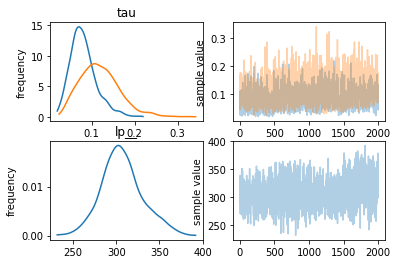

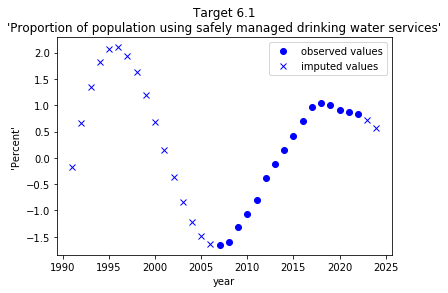

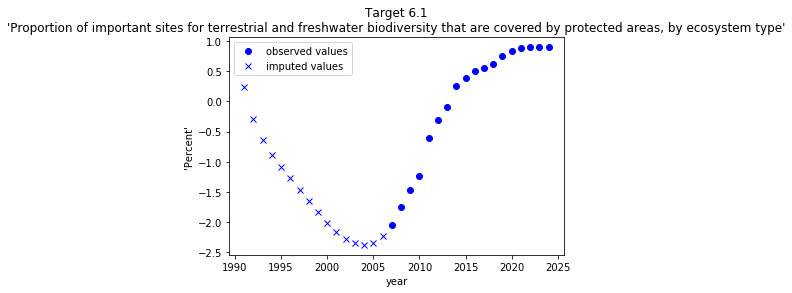

('12.2', '3.1')
Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.48    0.03   0.27  -0.92  -0.61  -0.56  -0.34   0.18    107   1.03
beta[1,0]     -0.37    0.05   0.44   -1.0  -0.71  -0.34  -0.21   0.67     85   1.03
beta[0,1]       1.4     0.1   0.29   0.62   1.23    1.5   1.59   1.81      9   1.12
beta[1,1]     -0.17    0.09   0.64  -1.41  -0.43   -0.3   0.32   1.06     48   1.09
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]    -0.25    0.03   0.42  -0.93  -0.58  -0.15  -0.11   0.75    231   1.02
Omega[0,1]    -0.25    0.03   0.42  -0.93  -0.58  -0.15  -0.11   0.75    231   1.02
Omega[1,1]      1.0 1.5e-186.7e-17    1.0    1.0    1.0    1.0    1.0   2000    nan
tau[0]         0.38    0.04   0.13   0.13

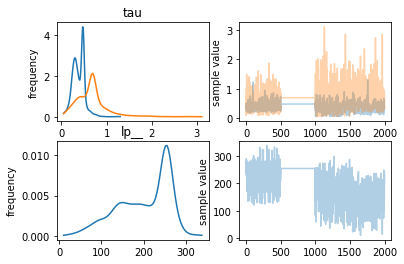

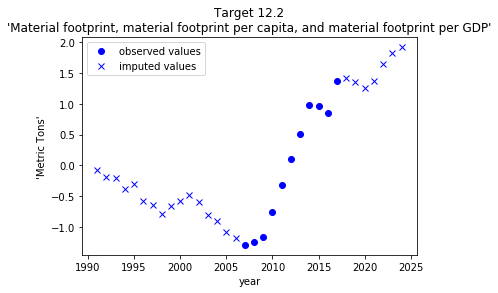

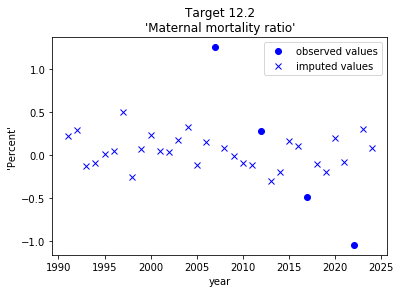

('15.1', '16.3')
Inference for Stan model: anon_model_c2c8db35d3d6b106a2010ff56a7e73b8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]     -0.79  7.3e-3    0.1  -0.96  -0.86  -0.81  -0.75  -0.55    194   1.03
beta[1,0]     -0.23    0.03   0.42  -0.93  -0.56  -0.25   0.07   0.59    149   1.03
beta[0,1]      1.76  7.3e-3    0.1   1.52   1.71   1.77   1.83   1.93    197   1.03
beta[1,1]     -0.03    0.08   0.59  -1.21  -0.39  -0.03   0.37   1.11     58   1.03
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   2000    nan
Omega[1,0]    -0.07    0.04   0.52  -0.89  -0.52  -0.09   0.37   0.85    201   1.01
Omega[0,1]    -0.07    0.04   0.52  -0.89  -0.52  -0.09   0.37   0.85    201   1.01
Omega[1,1]      1.0 1.7e-187.6e-17    1.0    1.0    1.0    1.0    1.0   2000    nan
tau[0]         0.09  3.8e-3   0.04   0.0

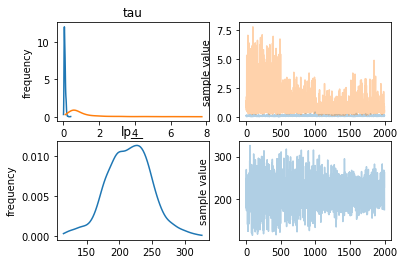

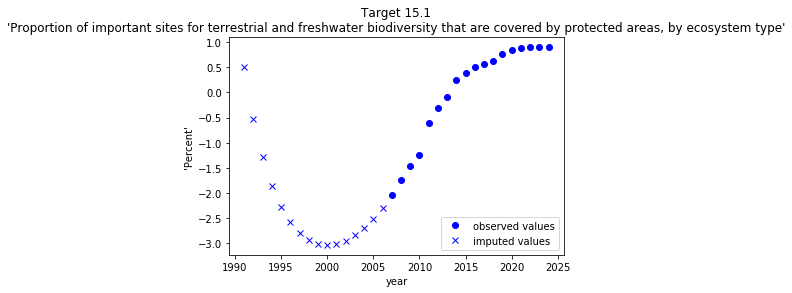

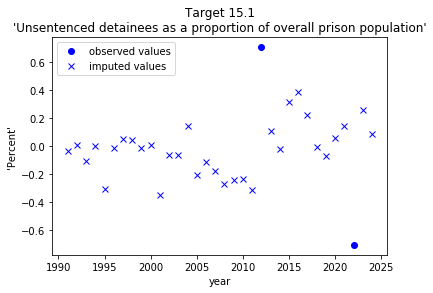

('8.4', '3.1')


KeyboardInterrupt: 

Process ForkPoolWorker-14:
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/GalinaJonat/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/GalinaJonat/anaconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/GalinaJonat/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/GalinaJonat/anaconda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/GalinaJonat/anaconda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/GalinaJonat/anaconda/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/GalinaJonat/anaconda/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/Users/

In [49]:
for pair in corrPairs:
    targetx = pair[0]
    targety = pair[1]

    # prepare input data
    inData = prepareInputData(final_t, targetx, targety)
    print(pair)

    # run inference using MCMC sampling
    fit = sm.sampling(data=inData, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
    print(fit)
    
    # what do we actually want to show? sigma and tau are performance measurements.
    fit.plot(["tau","lp__"]) # take vars from temporal model
    plt.show()

    samples = fit.extract(permuted=True)
    
    # get values for plots
    # convert indices back to year values
    ix_mis1 = inData['ix_mis1']+startyear
    ix_mis2 = inData['ix_mis2']+startyear
    ix_obs1 = inData['ix_obs1']+startyear
    ix_obs2 = inData['ix_obs2']+startyear
    
    y_mis1 = samples['y_mis1'].mean(axis=0)
    y_mis2 = samples['y_mis2'].mean(axis=0)
    y_obs1 = inData['y_obs1']
    y_obs2 = inData['y_obs2']
    
    
    # define title and labels from original dataframe
    y1_df = merged_df[merged_df['Target']==pair[0]]
    y2_df = merged_df[merged_df['Target']==pair[1]]
    y1_title = 'Target '+pair[0]+'\n'+str(y1_df['Indicator Description'].values).replace('[','').replace(']','')
    y1_label = str(y1_df['Unit'].values).replace('[','').replace(']','')
    y2_title = 'Target '+pair[0]+'\n'+str(y2_df['Indicator Description'].values).replace('[','').replace(']','')
    y2_label = str(y2_df['Unit'].values).replace('[','').replace(']','')
    
    # plot with imputed values of target 1
    plt.plot(ix_obs1, y_obs1, "bo")
    plt.plot(ix_mis1, y_mis1, "bx")
    plt.title(y1_title)
    plt.legend(["observed values","imputed values"])
    plt.xlabel('year')
    plt.ylabel(y1_label)
    plt.show()
    
    # plot with imputed values of target 2
    plt.plot(ix_obs2, y_obs2, "bo")
    plt.plot(ix_mis2, y_mis2, "bx")
    plt.title(y2_title)
    plt.legend(["observed values", "imputed values"])
    plt.xlabel('year')
    plt.ylabel(y2_label)
    plt.show()

## Conclusion
- We were able to prove that there are strong linear correlations (correlation coefficient higher than 0.98) between some targets.
- Some dependencies might still remain undiscovered which could be identified by a correlation different from a linear one, e.g. exponential
- We have to be critical about the imputed values in the years where data for both targets are missing (only dependant on the prior), but can be rather confident on imputed values that have an observation in the correlated target.
- Some of the predictions for y can only be given low confidence as the number of effective values used for this prediction is very low.

## Open questions: What we haven't understood so far

- Omega[1,0] is a value of Omega that gives us the correlation between Target 1 and 2. What kind of correlation measure is it? How can it be different/lower from our previously found Pearson r?


## Prospect: What we can do next
- use inferred values and/or identified relations to make predictions for the future based on assumptions of the development of one indicator
- find "plan of action" to improve one target/reach one target